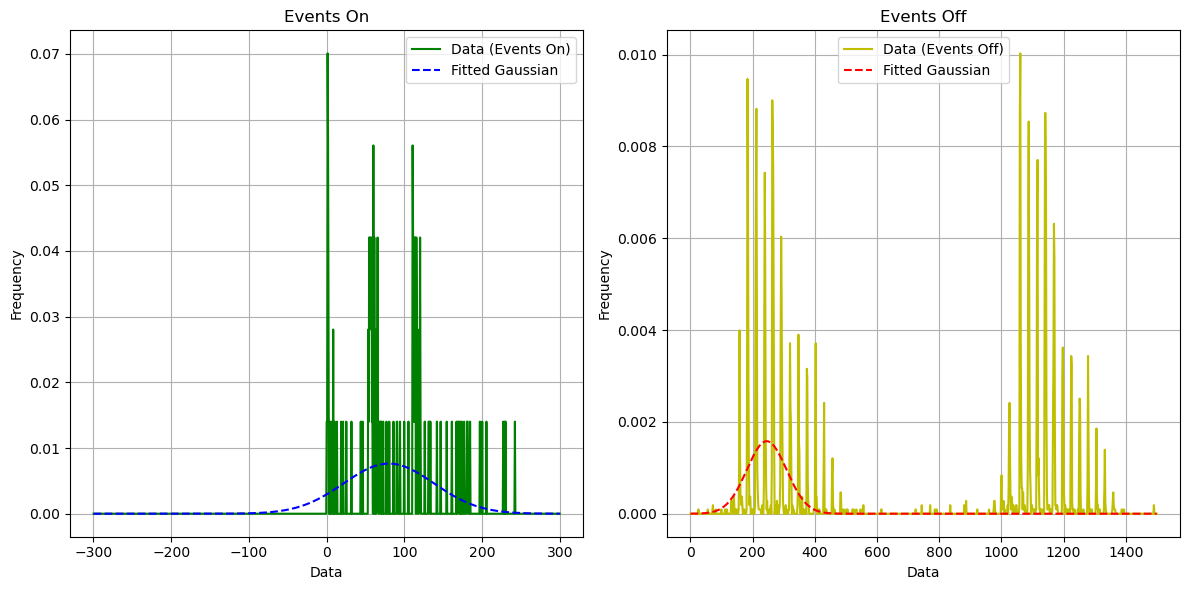

Spatial spread for events on: 579.3746159563198
Spatial spread for events off: 638.303344306998


In [143]:
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

'''Retinal outputs at a single frequency imported'''

import vertical_bars_neg_vel2  
import vertical_bars_pos_vel2

'''DO NOT change the retina data parameters!!!'''

retina_grid_size = 144 ##DONT CHANGE RETINA PARAMETERS!!!
retWinColLen = 12
retWinRowLen = 12
retTotalLen = 19

eventos_off = []
eventos_on = []

for loop in range(0, retWinRowLen):
    retCurrentPointer = retTotalLen * loop
    for current_indices in range(retCurrentPointer, retCurrentPointer + retWinColLen):
        eventos_off.append(np.asarray(vertical_bars_neg_vel2.eventos, dtype=object)[current_indices])
        eventos_on.append(np.asarray(vertical_bars_pos_vel2.eventos, dtype=object)[current_indices])

# Define parameters

# Calculate the spatial spread parameters cMUA and cLFP
# Flatten the data
flattened_events_on = np.concatenate(eventos_on)
flattened_events_off = np.concatenate(eventos_off)

# Histogram the data
bins1 = np.linspace(-270 ,270, 1000)  # Adjusted bins for events on
bins2 = np.linspace(0, 2800, 1000)  # Adjusted bins for events off

hist_on, bin_edges_on = np.histogram(flattened_events_on, bins=bins1, density=True)
hist_off, bin_edges_off = np.histogram(flattened_events_off, bins=bins2, density=True)

# Define new initial guesses for parameters
initial_guess_on = [0, 100, 1]  # For events on
initial_guess_off = [0, 100, 1]  # For events off

# Fit Gaussian to the data with lm method and scaled data
try:
    popt_on, pcov_on = curve_fit(gaussian, bin_centers_on, hist_on, p0=initial_guess_on, method='trf', ftol=1e-6, xtol=1e-6, maxfev=10000)
    popt_off, pcov_off = curve_fit(gaussian, bin_centers_off, hist_off, p0=initial_guess_off, method='trf', ftol=1e-6, xtol=1e-6, maxfev=10000)
except RuntimeError as e:
    print("Optimization failed:", e)

# Plot the data and the fitted Gaussian
plt.figure(figsize=(12, 6))

# Plot for events on
plt.subplot(1, 2, 1)
plt.plot(bin_centers_on, hist_on, color='g', label='Data (Events On)')
plt.plot(bin_centers_on, gaussian(bin_centers_on, *popt_on), color='b', linestyle='--', label='Fitted Gaussian')
plt.xlabel('Data')
plt.ylabel('Frequency')
plt.legend()
plt.title('Events On')
plt.grid(True)

# Plot for events off
plt.subplot(1, 2, 2)
plt.plot(bin_centers_off, hist_off, color='y', label='Data (Events Off)')
plt.plot(bin_centers_off, gaussian(bin_centers_off, *popt_off), color='r', linestyle='--', label='Fitted Gaussian')
plt.xlabel('Data')
plt.ylabel('Frequency')
plt.legend()
plt.title('Events Off')
plt.grid(True)

plt.tight_layout()
plt.show()

# Calculate spatial spread
spatial_spread_on = popt_on[1]*10  # Standard deviation of the Gaussian fit for events on
spatial_spread_off = popt_off[1]*10  # Standard deviation of the Gaussian fit for events off

print("Spatial spread for events on:", spatial_spread_on)
print("Spatial spread for events off:", spatial_spread_off)


Visual spread parameter for MUA (vMUA): 579.3746159563198
Visual spread parameter for LFP (vLFP): 638.303344306998
Spatial spread parameter for LFP (cLFP): 146.7618936738732


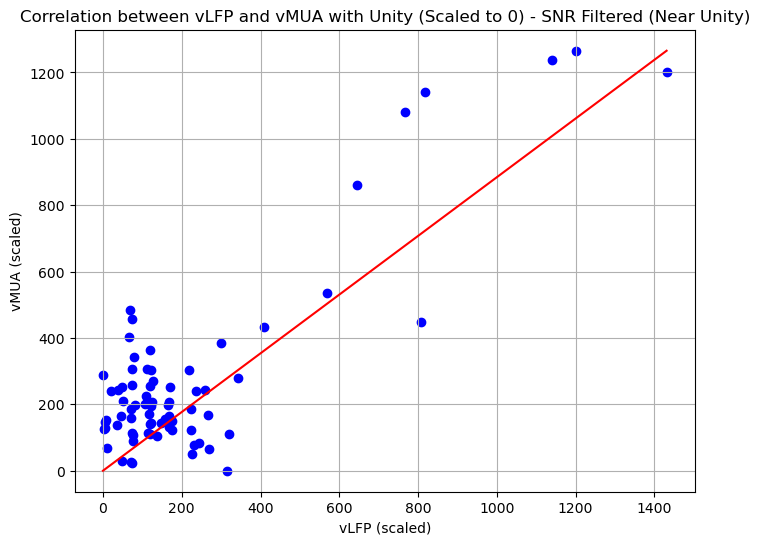

In [170]:
vMUA = spatial_spread_on
vLFP = spatial_spread_off
cMUA = 60 # assumption
MF = 0.5

cLFP = np.sqrt(MF**2 * vLFP**2 - MF**2 * vMUA**2 + cMUA**2)

# Define the range of y values (distance in degrees of visual angle)
y_values = np.linspace(-100, 100, 10)

# Define Gaussian functions for gcMUA(y) and gcLFP(y)
def gaussian(x, sigma):
    return np.exp(-x**2 / (2 * sigma**2))


print(f"Visual spread parameter for MUA (vMUA): {vMUA}")
print(f"Visual spread parameter for LFP (vLFP): {vLFP}")
print(f"Spatial spread parameter for LFP (cLFP): {cLFP}")
# Calculate vMUA and vLFP
vMUA = [np.max(row) - np.min(row) for row in eventos_on]
vLFP = [np.max(row) - np.min(row) for row in eventos_off]

# Calculate SNR for vMUA and vLFP
SNR_vMUA = [np.abs(np.max(row) - np.min(row)) / np.std(row) for row in eventos_on]
SNR_vLFP = [np.abs(np.max(row) - np.min(row)) / np.std(row) for row in eventos_off]
# Filter data points based on SNR criterion
vMUA_filtered = [vMUA[i] for i in range(len(vMUA)) if SNR_vMUA[i] >= 1.5]
vLFP_filtered = [vLFP[i] for i in range(len(vLFP)) if SNR_vLFP[i] >= 1.5]

# Scale to 0
vMUA_scaled = np.array(vMUA_filtered) - min(vMUA_filtered)
vLFP_scaled = np.array(vLFP_filtered) - min(vLFP_filtered)
# Calculate the absolute difference from unity line
abs_diff = np.abs(vMUA_scaled - vLFP_scaled)

# Define a threshold for the absolute difference
threshold = 500  # You can adjust this threshold as needed

# Filter data points based on the absolute difference criterion
vMUA_filtered_near_unity = [vMUA_scaled[i] for i in range(len(vMUA_scaled)) if abs_diff[i] <= threshold]
vLFP_filtered_near_unity = [vLFP_scaled[i] for i in range(len(vLFP_scaled)) if abs_diff[i] <= threshold]

if len(vMUA_filtered_near_unity) > 0 and len(vLFP_filtered_near_unity) > 0:
    # Plotting
    plt.figure(figsize=(8, 6))
    plt.scatter(vLFP_filtered_near_unity, vMUA_filtered_near_unity, color='blue')
    plt.plot([0, max(vLFP_filtered_near_unity)], [0, max(vMUA_filtered_near_unity)], color='red')
    plt.title('Correlation between vLFP and vMUA with Unity (Scaled to 0) - SNR Filtered (Near Unity)')
    plt.xlabel('vLFP (scaled)')
    plt.ylabel('vMUA (scaled)')
    plt.grid(True)
    plt.show()
else:
    print("No data points remaining after filtering.")



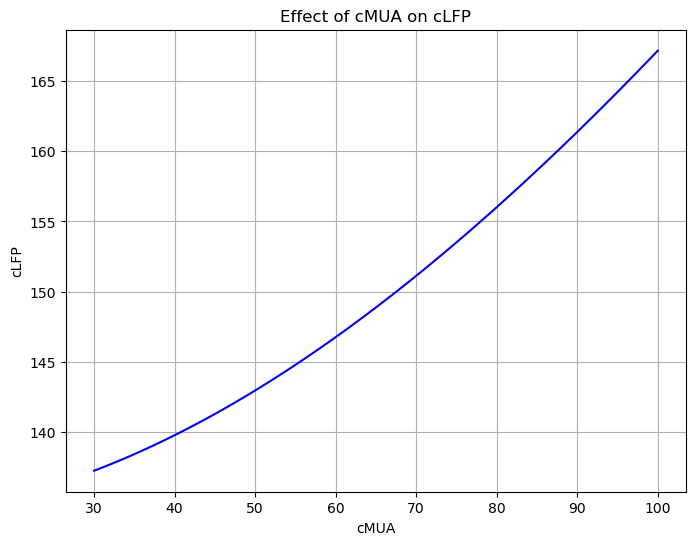

In [171]:

import numpy as np
import matplotlib.pyplot as plt

# Define the range of cMUA values
cMUA_values = np.linspace(30, 100, 100)

# Define spatial spread parameters
vMUA = spatial_spread_on
vLFP = spatial_spread_off
MF = 0.5

# Calculate cLFP for each cMUA value
cLFP_values = np.sqrt(MF**2 * vLFP**2 - MF**2 * vMUA**2 + cMUA_values**2)

# Plot the graph
plt.figure(figsize=(8, 6))
plt.plot(cMUA_values, cLFP_values, color='blue')
plt.title('Effect of cMUA on cLFP')
plt.xlabel('cMUA')
plt.ylabel('cLFP')
plt.grid(True)
plt.show()

    

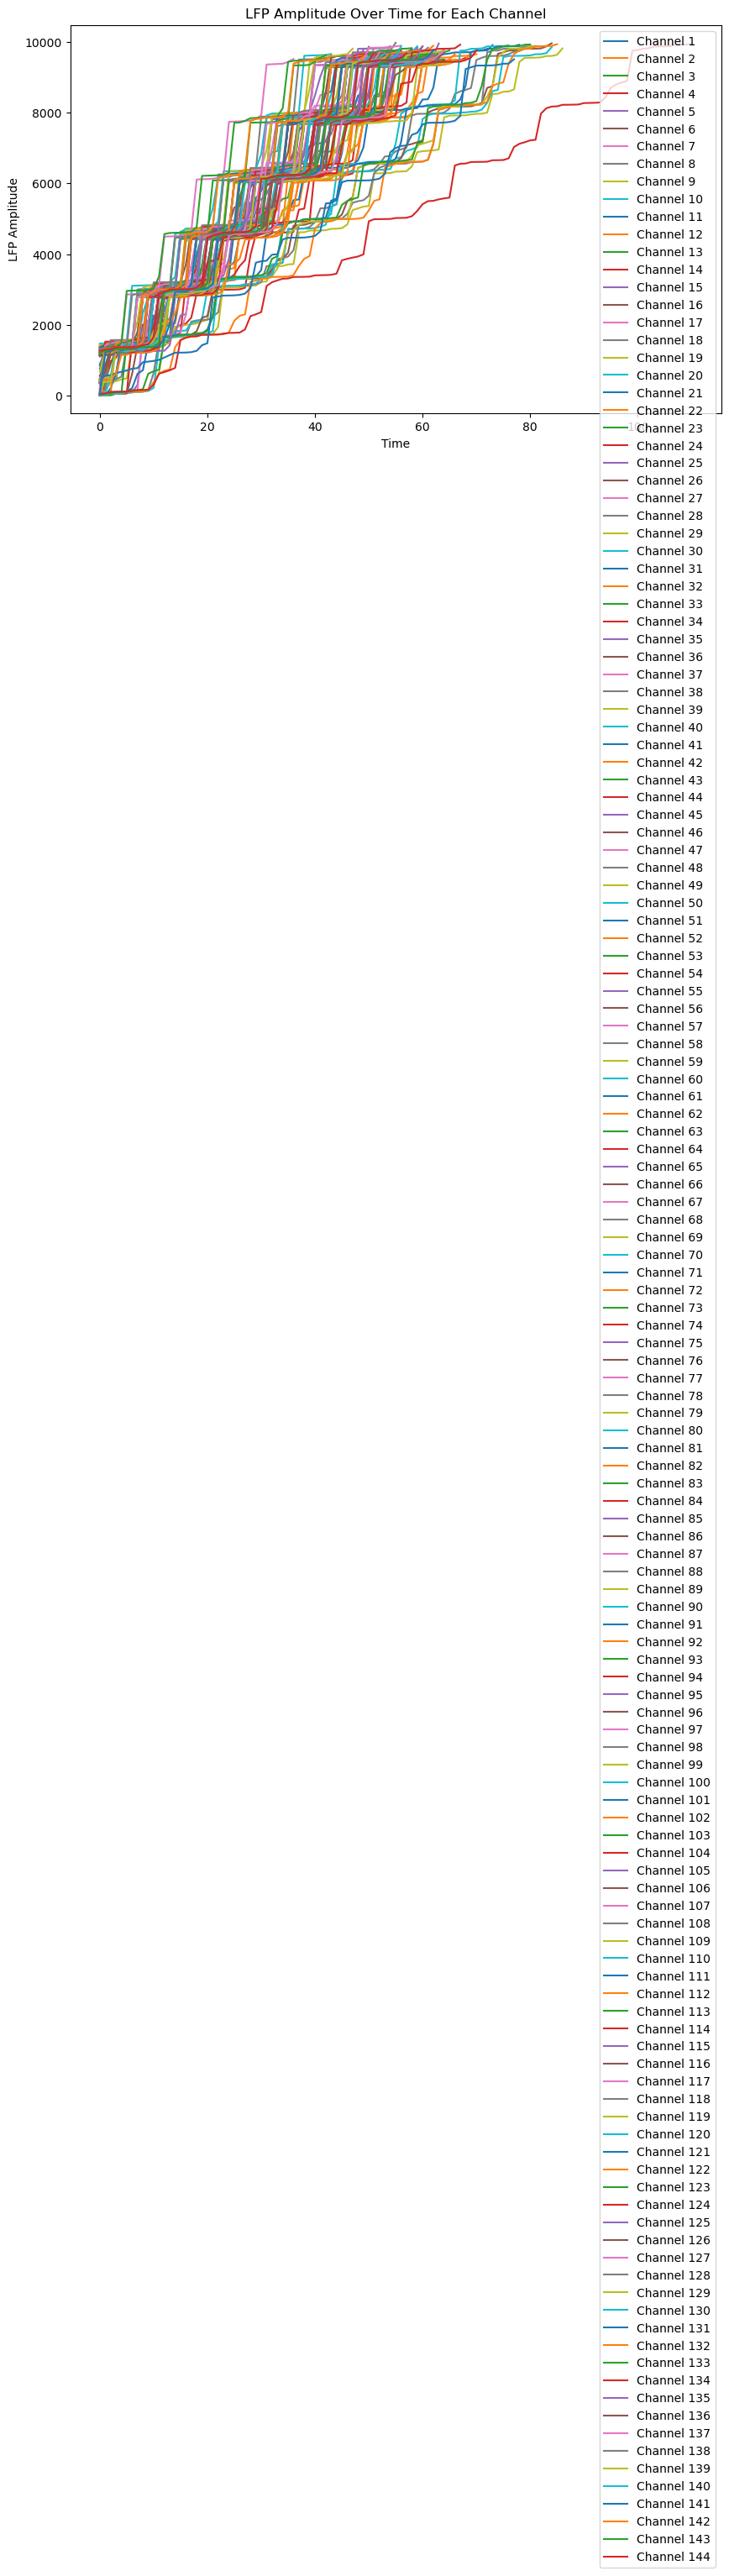

TypeError: Image data of dtype object cannot be converted to float

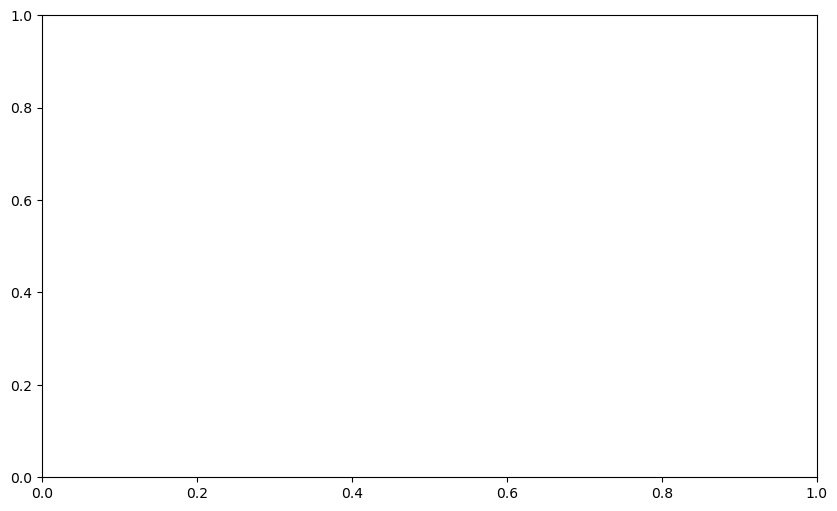

In [184]:
eventos = eventos_on

plt.figure(figsize=(10, 6))
for i, data in enumerate(eventos):
    plt.plot(data, label=f'Channel {i+1}')
plt.xlabel('Time')
plt.ylabel('LFP Amplitude')
plt.title('LFP Amplitude Over Time for Each Channel')
plt.legend()
plt.show()

# Heatmaps
plt.figure(figsize=(10, 6))
plt.imshow(eventos, cmap='viridis', aspect='auto', extent=[0, len(eventos[0]), len(eventos), 0])
plt.colorbar(label='LFP Amplitude')
plt.xlabel('Time')
plt.ylabel('Channel')
plt.title('LFP Heatmap')
plt.show()

# Surface Plots
X, Y = np.meshgrid(np.arange(len(eventos[0])), np.arange(len(eventos)))
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, eventos, cmap='viridis')
ax.set_xlabel('Time')
ax.set_ylabel('Channel')
ax.set_zlabel('LFP Amplitude')
ax.set_title('LFP Surface Plot')
plt.show()

# Stacked Area Plots
plt.figure(figsize=(10, 6))
plt.stackplot(range(len(eventos[0])), *eventos, labels=[f'Channel {i+1}' for i in range(len(eventos))])
plt.xlabel('Time')
plt.ylabel('LFP Amplitude')
plt.title('Stacked Area Plot of LFP')
plt.legend()
plt.show()

# Correlation Analysis
correlation_matrix = np.corrcoef(eventos)
plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar(label='Correlation Coefficient')
plt.title('Correlation Matrix between Channels')
plt.xlabel('Channel')
plt.ylabel('Channel')
plt.show()

# Fourier Analysis
fft_data = np.fft.fft(eventos)
frequencies = np.fft.fftfreq(len(eventos[0]))
plt.figure(figsize=(10, 6))
for i, data in enumerate(fft_data):
    plt.plot(frequencies, np.abs(data), label=f'Channel {i+1}')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('Frequency Analysis of LFP')
plt.legend()
plt.show()
